In [21]:
import os
import logging

import pandas as pd
import numpy as np 
import tensorflow as tf


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'




(<tf.Tensor 'IteratorGetNext:0' shape=(48, 192, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=() dtype=int64>)
(<tf.Tensor 'IteratorGetNext:2' shape=(19,) dtype=int64>, <tf.Tensor 'IteratorGetNext:3' shape=() dtype=int64>)
(array([21, 56, 37, 40, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1]), 4)
img: [0.36078432 0.36078432 0.36078432 0.36078432 0.36078432 0.36078432
 0.36078432 0.36078432 0.36078432 0.36078432 0.36078432 0.36078432
 0.3372549  0.3372549  0.34509805 0.34509805 0.34509805 0.29411766
 0.10588235 0.10588235 0.11372549 0.11372549 0.06666667 0.23529412
 0.23529412 0.3529412  0.34901962 0.34901962 0.34901962 0.3529412
 0.3529412  0.36078432 0.36078432 0.36078432 0.35686275 0.34901962
 0.34901962 0.36862746 0.36862746 0.36862746 0.29411766 0.29411766
 0.27450982 0.1882353  0.1882353  0.14901961 0.3019608  0.3019608
 0.3529412  0.36078432 0.36078432 0.33333334 0.34117648 0.34117648
 0.26666668 0.10980392 0.10980392 0.09411765 0.09411765 0.2392156

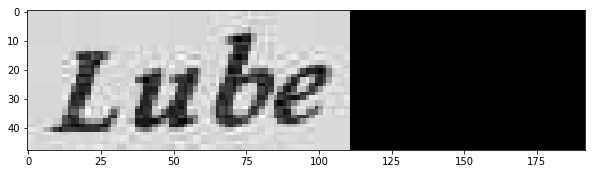

In [22]:
# Sanity check that we're getting images.

trn_dir = '/home/ubuntu/data/oxford_syntetic_text/TFrecords_sample/trn'
tfrecords_files_trn = [os.path.join(trn_dir, f) for f in os.listdir(trn_dir)]

def my_parser(serialized_example):
    """Parses a single tf.Example into image and label tensors."""
    features = tf.parse_single_example(
        serialized_example,
        features={'image/encoded': tf.FixedLenFeature([], tf.string),
                  'image/length': tf.FixedLenFeature([], tf.int64),
                  'image/height': tf.FixedLenFeature([], tf.int64),
                  'image/width': tf.FixedLenFeature([], tf.int64),
                  'image/label': tf.FixedLenFeature([19], tf.int64),
                  'image/label_length': tf.FixedLenFeature([], tf.int64)}
        )

    image = tf.image.decode_png(features['image/encoded'], dtype=tf.uint8)
    
    # Reshape from [depth * height * width] to [depth, height, width].
    image = tf.cast(
        tf.transpose(tf.reshape(image, [1, 48, 192]), [1, 2, 0]),
        tf.float32) / 255.0
    
    image_len = features['image/length']
    
    
    
    label = features['image/label']
    label_length = features['image/label_length']
    
    return (image, image_len), (label, label_length)

tf.reset_default_graph()

with tf.device('/cpu:0'):
    
    dataset = tf.data.TFRecordDataset(tfrecords_files_trn)
    dataset = dataset.map(my_parser, num_parallel_calls=1)
            
    (image, label) = dataset.make_one_shot_iterator().get_next()
    print(image)
    print(label)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    img, l = sess.run([image, label])
    
print(l)
print('img:', img[0][20,:,0])
plt.imshow(img[0][:,:,0], cmap='gray')

In [23]:
def adjust_image(img_file, x_size=192, y_size=48, x_blanks_ini=5):
    
    im = Image.open(img_file)
    if np.max(im)>0:
        x, y = im.size
        factor = y_size/y
        new_x = min( max(1, int(factor*x)), x_size-x_blanks_ini)
        if len(np.array(im.resize((new_x, y_size))).shape) == 3:
            img = np.array(im.resize((new_x, y_size)))[:,:,0]
        else:
            img = np.array(im.resize((new_x, y_size)))
        img_adjusted = np.concatenate([np.zeros((y_size, x_blanks_ini)), img], axis=1)
        new_x_size = img_adjusted.shape[1]
        if new_x_size < x_size:
            img_adjusted = np.concatenate([img_adjusted, np.zeros((y_size, x_size-new_x_size))], axis=1)

        if np.max(img_adjusted)>0:
            return img_adjusted
        else:
            return []
    else:
        return []


In [25]:
# Read images to score
data_path = '/home/ubuntu/data/oxford_syntetic_text/mnt/ramdisk/max/90kDICT32px'


df_test  = pd.read_csv(os.path.join(data_path,'annotation_test.txt' ), delimiter=' ', names=['file', 'n'])

images_score = []
for img_path in list(df_test.file)[:16]:
    img = adjust_image(os.path.join(data_path, img_path))
    if img_adjusted != []:
        images_score += [img]
        
images_score = np.array(images_score, dtype=np.uint8)

/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [26]:
images_score.shape

(16, 48, 192)

In [29]:
experiment_dir = '/home/ubuntu/data/oxford_syntetic_text/models'

experiment_name = 'test01'
      
checkpoint_name = 'model-4'
    
max_seq_size = 5


# Start interactive session
graph = tf.Graph()

gpu_options = tf.GPUOptions(allow_growth = True)

with tf.Session(graph=graph, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
 
    #Load model
    
    new_saver = tf.train.import_meta_graph(os.path.join(experiment_dir, experiment_name, checkpoint_name+'.meta'))
    new_saver.restore(sess, os.path.join(experiment_dir, experiment_name, checkpoint_name))
    
    images_batch = tf.placeholder(tf.uint8, shape=[None, 48, 192], name='filenames')
    iterator = tf.placeholder(tf.string, shape=[None])
    
    #images_batch = tf.get_collection('images_batch')[0]
    labels_batch = tf.get_collection('labels_batch')[0]
    logits = tf.get_collection('logits')[0]
    
    
    log  = sess.run(logits, feed_dict={images_batch: images_score})
        
        

INFO:tensorflow:Restoring parameters from /home/ubuntu/data/oxford_syntetic_text/models/test01/model-4


FailedPreconditionError: GetNext() failed because the iterator has not been initialized. Ensure that you have run the initializer operation for this iterator before getting the next element.
	 [[Node: inputs/IteratorGetNext = IteratorGetNext[output_shapes=[[?,48,192,1], [?], [?,19], [?]], output_types=[DT_FLOAT, DT_INT64, DT_INT64, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](inputs/Iterator)]]
	 [[Node: inputs/IteratorGetNext/_85 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_14_inputs/IteratorGetNext", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'inputs/IteratorGetNext', defined at:
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-0f5d02af7afa>", line 19, in <module>
    new_saver = tf.train.import_meta_graph(os.path.join(experiment_dir, experiment_name, checkpoint_name+'.meta'))
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1955, in import_meta_graph
    **kwargs)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tensorflow/python/framework/meta_graph.py", line 743, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tensorflow/python/framework/importer.py", line 513, in import_graph_def
    _ProcessNewOps(graph)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tensorflow/python/framework/importer.py", line 303, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3540, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3540, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3428, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/home/jorge/anaconda3/envs/tf18_1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): GetNext() failed because the iterator has not been initialized. Ensure that you have run the initializer operation for this iterator before getting the next element.
	 [[Node: inputs/IteratorGetNext = IteratorGetNext[output_shapes=[[?,48,192,1], [?], [?,19], [?]], output_types=[DT_FLOAT, DT_INT64, DT_INT64, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](inputs/Iterator)]]
	 [[Node: inputs/IteratorGetNext/_85 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_14_inputs/IteratorGetNext", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


(60, 1, 11)


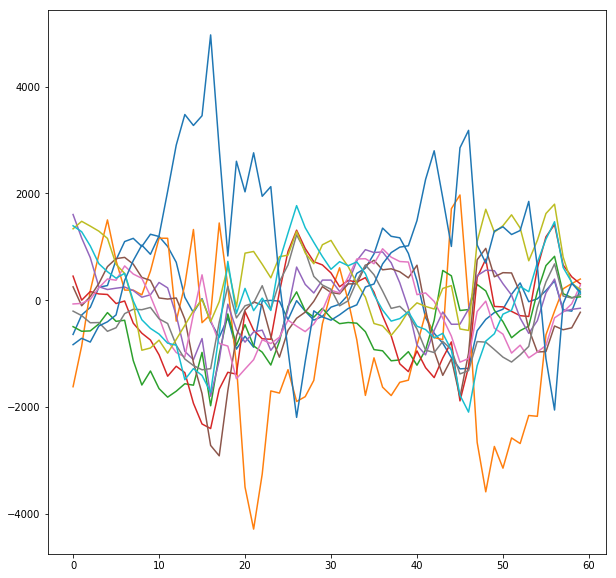

In [16]:
len(log)
print(log.shape)
plt.plot(log[:,0,:])

In [13]:
log

array([[[ -6.43423096e+02,  -1.62294653e+03,  -4.97441833e+02,
           4.49618011e+02,   1.60420227e+03,   2.48821457e+02,
          -7.20398178e+01,  -2.06440628e+02,   1.33635376e+03,
           1.39329041e+03,  -8.34528259e+02]],

       [[ -2.78725006e+02,  -8.61271240e+02,  -5.83610779e+02,
          -1.29278111e+00,   1.16437903e+03,  -1.05706398e+02,
          -6.16278610e+01,  -2.90326538e+02,   1.47686914e+03,
           1.28131531e+03,  -7.15693481e+02]],

       [[ -1.36867813e+02,   1.74158035e+02,  -5.77001160e+02,
           1.60530869e+02,   7.96631775e+02,   6.70575256e+01,
           1.42565413e+01,  -4.24497070e+02,   1.38710254e+03,
           1.01632892e+03,  -7.86433167e+02]],

       [[  2.41449783e+02,   8.53717163e+02,  -4.46205597e+02,
           1.15857262e+02,   2.51070938e+02,   3.11277557e+02,
           2.31310669e+02,  -4.20399017e+02,   1.29225647e+03,
           6.81993225e+02,  -4.84502075e+02]],

       [[  2.72742126e+02,   1.50317053e+03,  -2.338